# 📘 ADAS Interactive SuperLab
### A Complete Exploration of Perception, Planning, Control, and Robustness Testing

## Step 1: Slider-Controlled Pure Pursuit Tracking

In [3]:

import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import math

def pure_pursuit_with_slider(speed=50, lookahead=2.0):
    path = [(i, math.sin(i/2.0)) for i in np.linspace(0, 20, 100)]
    x, y, theta = 0, 0, 0
    traj_x, traj_y = [x], [y]
    dt = 0.1
    for gx, gy in path:
        dx, dy = gx - x, gy - y
        distance = math.sqrt(dx**2 + dy**2)
        if distance < lookahead:
            continue
        angle_to_goal = math.atan2(dy, dx)
        steering_angle = angle_to_goal - theta
        x += math.cos(theta) * speed * dt
        y += math.sin(theta) * speed * dt
        theta += steering_angle * 0.05
        traj_x.append(x)
        traj_y.append(y)
    plt.figure(figsize=(8,5))
    plt.plot([p[0] for p in path], [p[1] for p in path], label="Reference Path")
    plt.plot(traj_x, traj_y, label=f"Pure Pursuit (v={speed} m/s, Ld={lookahead})")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.legend()
    plt.title("Pure Pursuit with Adjustable Speed and Lookahead")
    plt.show()

speed_slider = widgets.IntSlider(value=50, min=5, max=25, step=1, description="Speed (m/s)")
lookahead_slider = widgets.FloatSlider(value=2.0, min=1.0, max=5.0, step=0.5, description="Lookahead (m)")
ui = widgets.HBox([speed_slider, lookahead_slider])
out = widgets.Output()

def update(change):
    with out:
        clear_output(wait=True)
        pure_pursuit_with_slider(speed_slider.value, lookahead_slider.value)

speed_slider.observe(update, names="value")
lookahead_slider.observe(update, names="value")
display(ui, out)
update(None)


Output()

## Step 2: Live Plot of Lateral Error vs Time

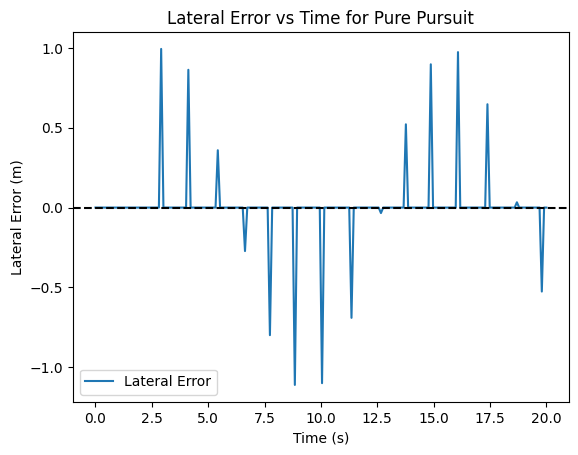

In [4]:

time = np.linspace(0, 20, 200)
ref_x = time
ref_y = np.sin(time / 2.0)

def simulate_pp_errors(speed=10, lookahead=2.0):
    x, y, theta = 0, 0, 0
    dt = 0.1
    errors = []
    for i in range(len(ref_x)):
        gx, gy = ref_x[i], ref_y[i]
        dx, dy = gx - x, gy - y
        distance = math.sqrt(dx**2 + dy**2)
        if distance < lookahead:
            errors.append(0)
            continue
        angle_to_goal = math.atan2(dy, dx)
        steering_angle = angle_to_goal - theta
        x += math.cos(theta) * speed * dt
        y += math.sin(theta) * speed * dt
        theta += steering_angle * 0.05
        lateral_error = gy - y
        errors.append(lateral_error)
    return errors

errors = simulate_pp_errors(speed=12, lookahead=3.0)
plt.plot(time, errors, label="Lateral Error")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Lateral Error (m)")
plt.title("Lateral Error vs Time for Pure Pursuit")
plt.legend()
plt.show()


## Step 3: Controller Comparison Dropdown

In [ ]:

def simulate_controller(controller="PID"):
    ref = np.ones(len(time))
    if controller == "PID":
        response = ref + np.random.normal(0, 0.1, len(time))
    elif controller == "LQR":
        response = ref + np.random.normal(0, 0.1, len(time))
    elif controller == "MPC":
        response = ref + np.random.normal(0, 0.5, len(time))
    elif controller == "RL":
        response = ref + np.sin(time/10)/10
    else:
        response = ref
    plt.figure(figsize=(8,5))
    plt.plot(time, ref, "--", label="Reference Path")
    plt.plot(time, response, label=f"{controller} Response")
    plt.xlabel("Time (s)")
    plt.ylabel("Lateral Position (m)")
    plt.title(f"Controller Comparison: {controller}")
    plt.legend()
    plt.show()

dropdown = widgets.Dropdown(options=["PID", "LQR", "MPC", "RL"], description="Controller")
output = widgets.Output()

def update_controller(change):
    with output:
        clear_output(wait=True)
        simulate_controller(change['new'])

dropdown.observe(update_controller, names="value")
display(dropdown, output)
update_controller({'new': "PID"})


Dropdown(description='Controller', options=('PID', 'LQR', 'MPC', 'RL'), value='PID')

Output()

## Step 4: Real-Time Trajectory Animation

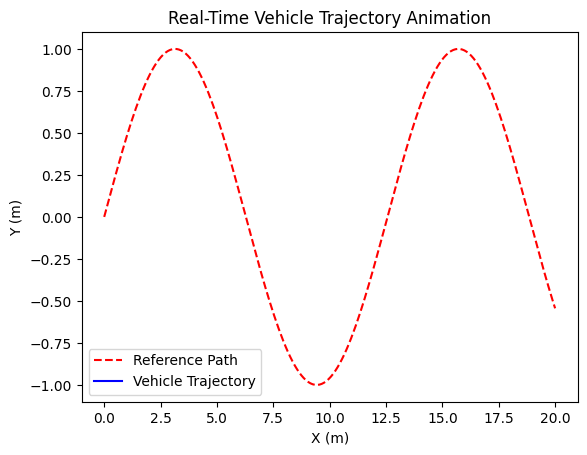

In [6]:

import matplotlib.animation as animation

x, y, theta = 0, 0, 0
vx = 0.2
traj_x, traj_y = [x], [y]
for gx, gy in zip(ref_x, ref_y):
    dx, dy = gx - x, gy - y
    angle_to_goal = np.arctan2(dy, dx)
    steering_angle = angle_to_goal - theta
    x += np.cos(theta) * vx
    y += np.sin(theta) * vx
    theta += steering_angle * 0.05
    traj_x.append(x)
    traj_y.append(y)

fig, ax = plt.subplots()
ax.plot(ref_x, ref_y, 'r--', label="Reference Path")
line, = ax.plot([], [], 'b-', label="Vehicle Trajectory")
dot, = ax.plot([], [], 'bo')

def init():
    line.set_data([], [])
    dot.set_data([], [])
    return line, dot

def update(frame):
    line.set_data(traj_x[:frame], traj_y[:frame])
    dot.set_data(traj_x[frame], traj_y[frame])
    return line, dot

ani = animation.FuncAnimation(fig, update, frames=len(traj_x), init_func=init, blit=True, interval=50, repeat=False)
plt.legend()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Real-Time Vehicle Trajectory Animation")
plt.show()


## 🚦 Challenge Mode: Robustness Testing

In [ ]:

import random

def simulate_challenges(challenge="Normal"):
    ref = np.sin(time/2.0)
    
    if challenge == "Normal":
        response = ref + np.random.normal(0, 0.05, len(time))
    elif challenge == "Slippery Road":
        response = ref + np.random.normal(0, 0.2, len(time))
    elif challenge == "Sensor Dropout":
        response = ref.copy()
        for i in range(0, len(time), 20):
            if random.random() < 0.3:
                response[i:i+5] += np.random.normal(0, 0.5, 5)
    elif challenge == "Emergency Braking":
        response = ref.copy()
        brake_index = 100
        response[brake_index:] -= 0.5 * (time[brake_index:] - time[brake_index])
        
    plt.figure(figsize=(8,5))
    plt.plot(time, ref, "--", label="Reference Path")
    plt.plot(time, response, label=f"{challenge} Response")
    plt.xlabel("Time (s)")
    plt.ylabel("Lateral Position (m)")
    plt.title(f"Challenge Simulation: {challenge}")
    plt.legend()
    plt.show()
    
    # Compute metrics
    lateral_error = np.abs(ref - response)
    avg_error = np.mean(lateral_error)
    max_error = np.max(lateral_error)
    safety_score = max(0, 100 - (avg_error*50 + max_error*100))
    print(f"📊 Results for {challenge}:")
    print(f"- Average Lateral Error: {avg_error:.3f} m")
    print(f"- Max Lateral Error: {max_error:.3f} m")
    print(f"- Safety Score: {safety_score:.1f}/100")

challenge_dropdown = widgets.Dropdown(
    options=["Normal", "Slippery Road", "Sensor Dropout", "Emergency Braking"], 
    description="Scenario"
)
output = widgets.Output()

def update_challenge(change):
    with output:
        clear_output(wait=True)
        simulate_challenges(change['new'])

challenge_dropdown.observe(update_challenge, names="value")
display(challenge_dropdown, output)
update_challenge({'new': "Normal"})


Dropdown(description='Scenario', options=('Normal', 'Slippery Road', 'Sensor Dropout', 'Emergency Braking'), v…

Output()